Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

качество предсказания;
скорость предсказания;
время обучения.

# 1. Подготовка данных

### 1.1 Загрузим необходимые библиотеки, датасет и получим общую информацию 

In [1]:
import pandas as pd
import xgboost as xgb
import catboost as ctb
import lightgbm as lgb
from sklearn.utils.validation import column_or_1d
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import make_scorer
from hyperopt import hp
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.preprocessing import StandardScaler

/Users/aleksandrsaraev/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
data = pd.read_csv('/Users/aleksandrsaraev/project/13_07_2020/autos.csv')
#data = pd.read_csv('/datasets/autos.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

## Выводы:
1. Представлен датасет из 354369 автомобилей. Всего признаков - 16, из них price - целевой признак.
2. Пропуски имеются в столбцах VehicleType,Gearbox,Model,FuelType, NotRepaired  

### 1.2 Рассмотрим каждый признак по отдельности

1.2.1 DateCrawled

In [3]:
data['DateCrawled'].sort_values()

329497    2016-03-05 14:06:22
220583    2016-03-05 14:06:23
176823    2016-03-05 14:06:24
99885     2016-03-05 14:06:24
324763    2016-03-05 14:06:24
                 ...         
204218    2016-04-07 14:36:53
53739     2016-04-07 14:36:54
301030    2016-04-07 14:36:55
339649    2016-04-07 14:36:56
90713     2016-04-07 14:36:58
Name: DateCrawled, Length: 354369, dtype: object

Переведем в формат Datetime

In [4]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  object        
 13  NumberOfPictures   354369 non-null  int64   

Даты скачивания производились в 2016 году в марте-апреле

1.2.2 Price

In [5]:
data['Price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

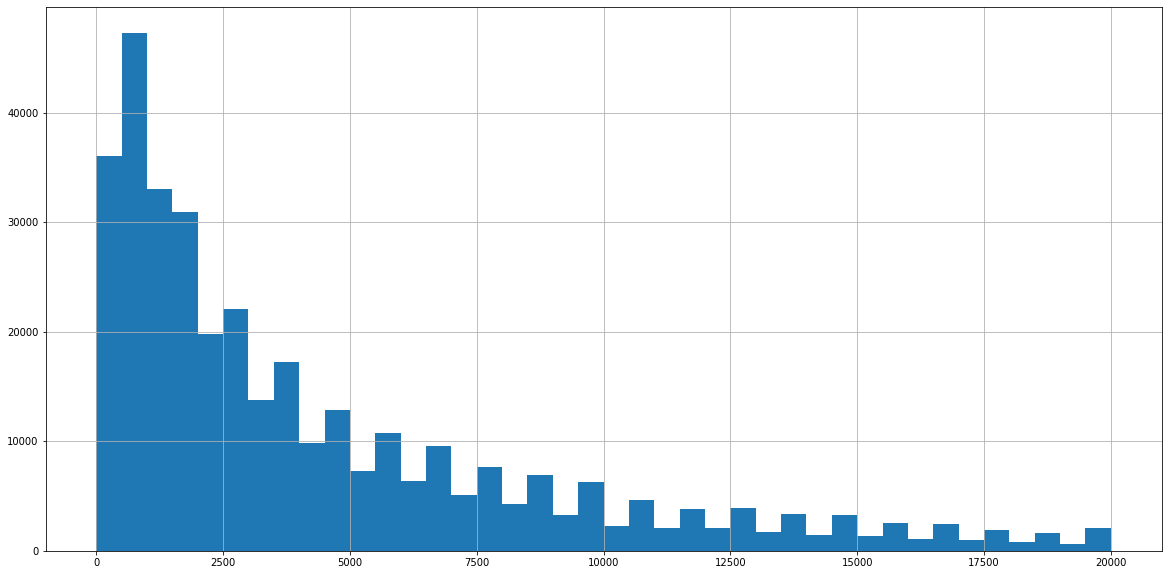

In [6]:
data['Price'].hist(figsize=(20, 10), bins=40)

Проверим цены ниже 50 евро

In [7]:
data.query('Price < 50')['Price'].value_counts()


0     10772
1      1189
10       84
30       55
20       51
40       45
25       33
15       27
5        26
35       18
45       16
2        12
49       12
8         9
3         8
12        8
9         8
13        7
39        6
17        5
11        5
14        5
18        3
19        3
7         3
29        2
16        2
26        1
27        1
33        1
4         1
21        1
38        1
32        1
24        1
47        1
Name: Price, dtype: int64

Проверим авто стоимостью 20000 евро

In [8]:
data.query('Price == 20000')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1515,2016-03-09 10:18:36,20000,sedan,2010,auto,239,a6,150000,5,gasoline,audi,no,2016-03-07 00:00:00,0,56567,2016-03-30 19:17:04
1586,2016-04-03 21:41:49,20000,sedan,2014,auto,184,leon,40000,4,gasoline,seat,no,2016-04-03 00:00:00,0,30655,2016-04-05 22:18:39
2128,2016-03-30 09:50:58,20000,sedan,2014,manual,135,ceed,30000,3,petrol,kia,no,2016-03-30 00:00:00,0,39307,2016-03-30 10:44:12
3728,2016-03-28 14:25:18,20000,sedan,2011,auto,265,c_klasse,50000,11,gasoline,mercedes_benz,no,2016-03-28 00:00:00,0,60311,2016-03-28 15:07:23
6286,2016-04-01 11:55:42,20000,sedan,2009,auto,272,e_klasse,150000,9,gasoline,mercedes_benz,no,2016-04-01 00:00:00,0,41749,2016-04-07 08:17:24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342303,2016-03-29 20:54:22,20000,sedan,2013,manual,194,insignia,60000,10,gasoline,opel,no,2016-03-29 00:00:00,0,76698,2016-04-06 07:17:21
346165,2016-03-25 17:53:40,20000,NaN,2016,auto,507,m_reihe,150000,6,NaN,bmw,NaN,2016-03-25 00:00:00,0,94032,2016-04-02 22:52:36
348208,2016-03-07 17:51:17,20000,sedan,2011,auto,241,lancer,40000,2,petrol,mitsubishi,no,2016-03-07 00:00:00,0,97737,2016-04-06 19:18:11
349230,2016-04-02 20:47:00,20000,bus,2008,auto,204,viano,125000,1,gasoline,mercedes_benz,no,2016-04-02 00:00:00,0,55232,2016-04-06 21:17:36


Можно сказать, что стоимость соотносится с моделью и мощностью авто, за исключением,например киа или опель. Возможно они покрыты стразами сваровски)).

В целом цены варьируются от 0 до 20000. В среднем стоимость авто составляет 2700. Значений от 0 до 50 евро около 12000, что составляет около 3%. Удалим данные выбросы, т.к. они будут мешать обучению

In [9]:
data = data.query('Price > 50')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341619 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        341619 non-null  datetime64[ns]
 1   Price              341619 non-null  int64         
 2   VehicleType        308775 non-null  object        
 3   RegistrationYear   341619 non-null  int64         
 4   Gearbox            325072 non-null  object        
 5   Power              341619 non-null  int64         
 6   Model              324506 non-null  object        
 7   Kilometer          341619 non-null  int64         
 8   RegistrationMonth  341619 non-null  int64         
 9   FuelType           313041 non-null  object        
 10  Brand              341619 non-null  object        
 11  NotRepaired        276930 non-null  object        
 12  DateCreated        341619 non-null  object        
 13  NumberOfPictures   341619 non-null  int64   

1.2.3 VehicleType

In [10]:
data['VehicleType'].value_counts()

sedan          89130
small          77674
wagon          63502
bus            28269
convertible    19819
coupe          15563
suv            11764
other           3054
Name: VehicleType, dtype: int64

In [11]:
data[data['VehicleType'].isna()]['Model'].nunique()

238

1. Всего представлено 8 типов кузовов
2. Заполнить пропуски согласно моделям авто будет не совсем точным, т.к. у большинство моделей есть различные модификации кузовов, а также моделей с пропусками много - 238. Поэтому удалим пропуски.

In [12]:
data.dropna(subset = ['VehicleType'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308775 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        308775 non-null  datetime64[ns]
 1   Price              308775 non-null  int64         
 2   VehicleType        308775 non-null  object        
 3   RegistrationYear   308775 non-null  int64         
 4   Gearbox            299669 non-null  object        
 5   Power              308775 non-null  int64         
 6   Model              296981 non-null  object        
 7   Kilometer          308775 non-null  int64         
 8   RegistrationMonth  308775 non-null  int64         
 9   FuelType           294478 non-null  object        
 10  Brand              308775 non-null  object        
 11  NotRepaired        261333 non-null  object        
 12  DateCreated        308775 non-null  object        
 13  NumberOfPictures   308775 non-null  int64   

1.2.4 RegistrationYear

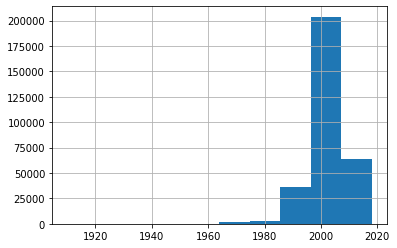

In [13]:
data['RegistrationYear'].hist()

Проверим выбросы до 1960 года

In [14]:
data.query('RegistrationYear < 1960')['RegistrationYear'].value_counts()

1959    29
1956    26
1958    20
1950    14
1953    14
1957    13
1955    13
1937    10
1910    10
1951    10
1954     9
1938     8
1952     8
1929     6
1945     4
1943     4
1932     3
1935     3
1936     3
1940     2
1941     2
1944     2
1934     2
1933     2
1947     2
1930     2
1948     2
1928     2
1923     2
1942     2
1949     1
1946     1
1931     1
1927     1
1925     1
Name: RegistrationYear, dtype: int64

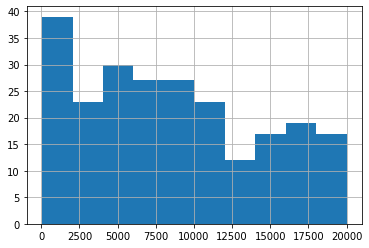

In [15]:
data.query('RegistrationYear < 1960')['Price'].hist()

Не думаю, что автомобиль таких годов может стоить дешевле 2000 евро. Поэтому удалим данные значения

In [16]:
drop = data.query('RegistrationYear < 1960 and Price < 2000')
data.drop(index = drop.index, inplace=True)

Проверим нет ли годов, больше 2016

In [17]:
data.query('RegistrationYear > 2016')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
43511,2016-03-24 12:48:09,9999,wagon,2017,manual,102,a3,90000,8,petrol,audi,no,2016-03-24 00:00:00,0,97855,2016-04-03 02:45:47
54271,2016-03-14 14:50:31,2350,sedan,2017,auto,170,5er,150000,6,petrol,bmw,no,2016-03-14 00:00:00,0,66540,2016-04-06 21:16:48
55054,2016-03-11 07:36:20,6800,suv,2017,NaN,0,other,70000,4,other,toyota,NaN,2016-03-11 00:00:00,0,90763,2016-03-28 08:45:17
56666,2016-03-20 19:39:52,9000,wagon,2017,auto,105,a3,80000,3,NaN,audi,no,2016-03-20 00:00:00,0,15834,2016-04-07 03:17:54
58434,2016-03-19 15:37:44,3800,wagon,2017,auto,0,vectra,150000,0,gasoline,opel,NaN,2016-03-19 00:00:00,0,38304,2016-04-02 22:46:26
62751,2016-03-20 21:50:47,1499,small,2018,manual,0,NaN,150000,5,petrol,mazda,NaN,2016-03-20 00:00:00,0,94315,2016-04-07 11:17:39
82608,2016-03-09 02:03:03,4750,sedan,2018,manual,0,polo,150000,12,gasoline,volkswagen,no,2016-03-09 00:00:00,0,24944,2016-04-07 11:44:35
97671,2016-03-22 18:54:48,2350,sedan,2017,auto,170,5er,150000,6,petrol,bmw,no,2016-03-22 00:00:00,0,66540,2016-04-07 08:16:35
130706,2016-03-15 21:43:53,11950,bus,2017,manual,130,transporter,150000,7,gasoline,volkswagen,no,2016-03-15 00:00:00,0,39114,2016-03-17 18:17:50
159345,2016-03-21 20:39:33,1900,small,2018,manual,75,polo,150000,12,petrol,volkswagen,no,2016-03-21 00:00:00,0,30855,2016-03-28 17:48:41


Есть данные за 2017 и 2018, что не соответствует датам скачивания данных. Удалим данные

In [18]:
drop_2016 = data.query('RegistrationYear > 2016')
data.drop(index = drop_2016.index, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308718 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        308718 non-null  datetime64[ns]
 1   Price              308718 non-null  int64         
 2   VehicleType        308718 non-null  object        
 3   RegistrationYear   308718 non-null  int64         
 4   Gearbox            299627 non-null  object        
 5   Power              308718 non-null  int64         
 6   Model              296944 non-null  object        
 7   Kilometer          308718 non-null  int64         
 8   RegistrationMonth  308718 non-null  int64         
 9   FuelType           294436 non-null  object        
 10  Brand              308718 non-null  object        
 11  NotRepaired        261301 non-null  object        
 12  DateCreated        308718 non-null  object        
 13  NumberOfPictures   308718 non-null  int64   

1.2.5 Gearbox

In [19]:
data['Gearbox'].value_counts()

manual    238630
auto       60997
Name: Gearbox, dtype: int64

Имеем 2 типа коробок - ручная и автоматическая. Пропуски здесь заполнить невозможно, поэтому удалим их

In [20]:
data.dropna(subset=['Gearbox'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299627 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        299627 non-null  datetime64[ns]
 1   Price              299627 non-null  int64         
 2   VehicleType        299627 non-null  object        
 3   RegistrationYear   299627 non-null  int64         
 4   Gearbox            299627 non-null  object        
 5   Power              299627 non-null  int64         
 6   Model              288744 non-null  object        
 7   Kilometer          299627 non-null  int64         
 8   RegistrationMonth  299627 non-null  int64         
 9   FuelType           287152 non-null  object        
 10  Brand              299627 non-null  object        
 11  NotRepaired        256018 non-null  object        
 12  DateCreated        299627 non-null  object        
 13  NumberOfPictures   299627 non-null  int64   

1.2.6 Power

In [21]:
data['Power'].describe()

count    299627.000000
mean        117.252661
std         185.005795
min           0.000000
25%          75.000000
50%         109.000000
75%         147.000000
max       20000.000000
Name: Power, dtype: float64

Проверим гистограмму с мощностью авто от 0 до 100

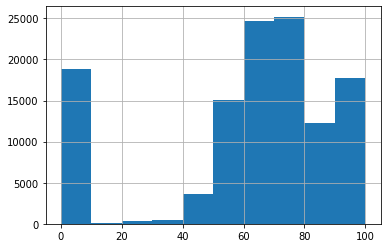

In [22]:
data['Power'].hist(range=(0, 100))

Т.к нулевых значений много, попробуем их заполнить медианой мощности данной модели

In [23]:
def power(model):
    med = data.loc[data['Model'] == model, 'Power'].median()
    data.loc[data['Model'] == model, 'Power'] = data.loc[data['Model'] == model, 'Power'].replace(0, med)
    return data
models = []
for row in data['Model'].unique():
    models.append(row)
for row in models:
    power(row)


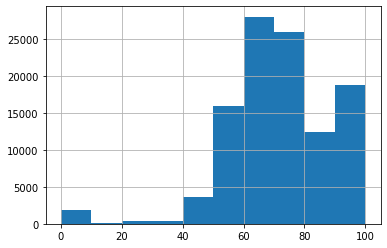

In [24]:
data['Power'].hist(range=(0, 100))

In [25]:
data.query('Power == 0')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
160,2016-03-19 19:49:15,500,small,1999,manual,0.0,NaN,150000,0,petrol,renault,no,2016-03-19 00:00:00,0,26969,2016-04-01 11:17:48
308,2016-03-13 13:38:54,1600,wagon,1999,manual,0.0,NaN,150000,6,petrol,bmw,no,2016-03-13 00:00:00,0,41199,2016-03-28 12:46:35
361,2016-03-23 23:57:07,300,small,2001,manual,0.0,NaN,150000,5,petrol,peugeot,yes,2016-03-23 00:00:00,0,84579,2016-03-25 15:22:13
706,2016-03-21 14:47:07,1690,small,2000,auto,0.0,NaN,125000,12,petrol,smart,no,2016-03-21 00:00:00,0,25421,2016-04-02 09:17:08
887,2016-03-24 08:51:43,250,small,1993,manual,0.0,NaN,150000,1,petrol,volkswagen,yes,2016-03-24 00:00:00,0,29331,2016-03-30 08:18:28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352532,2016-03-16 11:51:01,500,wagon,2003,manual,0.0,NaN,150000,7,gasoline,ford,yes,2016-03-16 00:00:00,0,61137,2016-03-17 09:18:23
353237,2016-03-28 19:56:52,300,sedan,2001,auto,0.0,NaN,150000,4,NaN,chrysler,yes,2016-03-28 00:00:00,0,64807,2016-04-07 02:17:59
353670,2016-03-28 10:55:28,2999,wagon,1998,manual,0.0,NaN,150000,0,petrol,mercedes_benz,NaN,2016-03-28 00:00:00,0,38875,2016-04-06 13:44:48
353982,2016-03-15 13:57:24,1500,bus,1984,manual,0.0,NaN,150000,5,gasoline,mercedes_benz,NaN,2016-03-15 00:00:00,0,48282,2016-04-06 03:46:28


Остались нулевые значения для моделей с пропусками. Удалим их:

In [26]:
data = data.query('Power > 0')

Проверим мощности больше 600

In [27]:
data.query('Power > 600')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1816,2016-03-22 20:52:00,3200,small,2004,manual,1398.0,corolla,5000,6,petrol,toyota,no,2016-03-22 00:00:00,0,22043,2016-03-22 21:43:26
4060,2016-04-03 20:31:00,3100,sedan,2005,manual,953.0,colt,150000,4,gasoline,mitsubishi,no,2016-04-03 00:00:00,0,60326,2016-04-07 14:56:46
5328,2016-03-29 19:44:48,500,wagon,1999,manual,1001.0,astra,150000,7,petrol,opel,NaN,2016-03-29 00:00:00,0,33154,2016-04-06 05:44:36
6296,2016-03-31 23:50:47,599,small,2002,manual,603.0,matiz,5000,11,petrol,chevrolet,yes,2016-03-31 00:00:00,0,44379,2016-04-01 03:41:52
6504,2016-03-14 15:54:34,3000,small,2009,manual,771.0,punto,125000,0,petrol,fiat,NaN,2016-03-14 00:00:00,0,40721,2016-03-14 15:54:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348668,2016-03-05 17:53:09,1000,wagon,1996,manual,2598.0,a6,150000,7,NaN,audi,NaN,2016-03-05 00:00:00,0,7646,2016-03-07 16:17:01
348883,2016-03-13 11:51:57,7500,sedan,2011,manual,1548.0,scenic,90000,4,petrol,renault,NaN,2016-03-13 00:00:00,0,24568,2016-04-06 15:17:39
348968,2016-04-04 18:53:25,250,small,1999,manual,1241.0,ypsilon,150000,5,petrol,lancia,yes,2016-04-04 00:00:00,0,28259,2016-04-04 18:53:25
351947,2016-03-07 21:36:19,1500,bus,2001,manual,1001.0,zafira,5000,7,gasoline,opel,no,2016-03-07 00:00:00,0,66117,2016-03-09 12:47:08


Данных выбросов немного, поэтому удалим их

In [28]:
data = data.query('Power < 600')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297590 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        297590 non-null  datetime64[ns]
 1   Price              297590 non-null  int64         
 2   VehicleType        297590 non-null  object        
 3   RegistrationYear   297590 non-null  int64         
 4   Gearbox            297590 non-null  object        
 5   Power              297590 non-null  float64       
 6   Model              288482 non-null  object        
 7   Kilometer          297590 non-null  int64         
 8   RegistrationMonth  297590 non-null  int64         
 9   FuelType           285630 non-null  object        
 10  Brand              297590 non-null  object        
 11  NotRepaired        254882 non-null  object        
 12  DateCreated        297590 non-null  object        
 13  NumberOfPictures   297590 non-null  int64   

1.2.7 Model

In [29]:
data['Model'].value_counts()

golf                  23857
other                 21248
3er                   17546
polo                  10827
corsa                 10344
                      ...  
serie_2                   6
kalina                    6
rangerover                3
serie_3                   3
range_rover_evoque        2
Name: Model, Length: 249, dtype: int64

Всего представлено 249 моделей. Пропуски восстановить невозможно, поэтому удалим их

In [30]:
data.dropna(subset=['Model'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288482 entries, 2 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        288482 non-null  datetime64[ns]
 1   Price              288482 non-null  int64         
 2   VehicleType        288482 non-null  object        
 3   RegistrationYear   288482 non-null  int64         
 4   Gearbox            288482 non-null  object        
 5   Power              288482 non-null  float64       
 6   Model              288482 non-null  object        
 7   Kilometer          288482 non-null  int64         
 8   RegistrationMonth  288482 non-null  int64         
 9   FuelType           278120 non-null  object        
 10  Brand              288482 non-null  object        
 11  NotRepaired        248410 non-null  object        
 12  DateCreated        288482 non-null  object        
 13  NumberOfPictures   288482 non-null  int64   

1.2.8 Kilometer

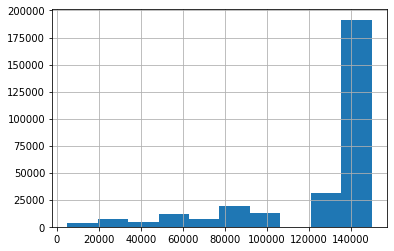

In [31]:
data['Kilometer'].hist()

In [32]:
data['Kilometer'].describe()

count    288482.000000
mean     128405.307784
std       36610.086282
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

Все пробеги адекватные

1.2.9 RegistrationMonth

In [33]:
data['RegistrationMonth'].value_counts()

3     30065
6     26819
4     25090
5     24889
7     23324
10    22541
12    20864
11    20717
9     20682
1     19795
8     19357
2     18453
0     15886
Name: RegistrationMonth, dtype: int64

Имеются данные с нулевым месяцем. Оставим данные выбросы, т.к. месяц не сильно влияет на стоимость авто

1.2.10 FuelType

In [34]:
data['FuelType'].value_counts()

petrol      185253
gasoline     87540
lpg           4512
cng            482
hybrid         189
other           87
electric        57
Name: FuelType, dtype: int64

Имеются 6 видов топлива, т.к. petrol и gasoline - это одно и тоже (бензин). Пропуски за невозможностью восстановить удалим, а бензин объединим в одно наименование


In [35]:
data.dropna(subset=['FuelType'], inplace=True)
data['FuelType'] = data['FuelType'].replace('gasoline', 'petrol')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278120 entries, 2 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        278120 non-null  datetime64[ns]
 1   Price              278120 non-null  int64         
 2   VehicleType        278120 non-null  object        
 3   RegistrationYear   278120 non-null  int64         
 4   Gearbox            278120 non-null  object        
 5   Power              278120 non-null  float64       
 6   Model              278120 non-null  object        
 7   Kilometer          278120 non-null  int64         
 8   RegistrationMonth  278120 non-null  int64         
 9   FuelType           278120 non-null  object        
 10  Brand              278120 non-null  object        
 11  NotRepaired        241783 non-null  object        
 12  DateCreated        278120 non-null  object        
 13  NumberOfPictures   278120 non-null  int64   

1.2.11 Brand

In [36]:
data['Brand'].nunique()

39

In [37]:
data['Brand'].value_counts()

volkswagen       59234
bmw              30548
opel             30188
mercedes_benz    26844
audi             24179
ford             19697
renault          13481
peugeot           8785
fiat              7300
seat              5458
skoda             4843
mazda             4476
citroen           4118
toyota            3952
nissan            3944
smart             3734
hyundai           2984
mini              2861
volvo             2739
mitsubishi        2341
honda             2158
kia               2025
suzuki            1857
alfa_romeo        1835
chevrolet         1437
chrysler          1127
dacia              785
porsche            605
subaru             598
daihatsu           598
jeep               561
land_rover         473
saab               448
jaguar             438
daewoo             399
lancia             347
rover              311
trabant            249
lada               163
Name: Brand, dtype: int64

Имеем 39 брэндов автомобилей. Основную долю занимает немецкий автопром

1.2.12 NotRepaired

In [38]:
data['NotRepaired'].value_counts()

no     215426
yes     26357
Name: NotRepaired, dtype: int64

Имеем 2 показателя - была и не была авария. Оставим пропуски, предположим, что человек не знает, были ли аварии или нет. Заполним пропуски unknown

In [39]:
data['NotRepaired'] = data['NotRepaired'].fillna('unknown')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278120 entries, 2 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        278120 non-null  datetime64[ns]
 1   Price              278120 non-null  int64         
 2   VehicleType        278120 non-null  object        
 3   RegistrationYear   278120 non-null  int64         
 4   Gearbox            278120 non-null  object        
 5   Power              278120 non-null  float64       
 6   Model              278120 non-null  object        
 7   Kilometer          278120 non-null  int64         
 8   RegistrationMonth  278120 non-null  int64         
 9   FuelType           278120 non-null  object        
 10  Brand              278120 non-null  object        
 11  NotRepaired        278120 non-null  object        
 12  DateCreated        278120 non-null  object        
 13  NumberOfPictures   278120 non-null  int64   

2.1.13 DateCreated

In [40]:
data['DateCreated'].sort_values()

4001      2015-03-20 00:00:00
86601     2015-08-07 00:00:00
175103    2015-08-10 00:00:00
75598     2015-09-04 00:00:00
221002    2015-09-04 00:00:00
                 ...         
43234     2016-04-07 00:00:00
106497    2016-04-07 00:00:00
230300    2016-04-07 00:00:00
11652     2016-04-07 00:00:00
81907     2016-04-07 00:00:00
Name: DateCreated, Length: 278120, dtype: object

Объявления созданы в 2015 и 2016 годах. Изменим тип данных на datetime

In [41]:
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M:%S')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278120 entries, 2 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        278120 non-null  datetime64[ns]
 1   Price              278120 non-null  int64         
 2   VehicleType        278120 non-null  object        
 3   RegistrationYear   278120 non-null  int64         
 4   Gearbox            278120 non-null  object        
 5   Power              278120 non-null  float64       
 6   Model              278120 non-null  object        
 7   Kilometer          278120 non-null  int64         
 8   RegistrationMonth  278120 non-null  int64         
 9   FuelType           278120 non-null  object        
 10  Brand              278120 non-null  object        
 11  NotRepaired        278120 non-null  object        
 12  DateCreated        278120 non-null  datetime64[ns]
 13  NumberOfPictures   278120 non-null  int64   

1.2.14 NumberOfPictures

In [42]:
data['NumberOfPictures'].unique()

array([0])

Все объявления без фото. Данный признак можно не использовать в обучении

1.2.15 PostalCode

In [43]:
data['PostalCode'].nunique()

8090

Всего представлено 8090 регионов

1.2.16 LastSeen

In [44]:
data['LastSeen'].sort_values()

262341    2016-03-05 14:15:16
169065    2016-03-05 14:25:59
232700    2016-03-05 14:35:28
45880     2016-03-05 14:44:11
108863    2016-03-05 14:44:41
                 ...         
59506     2016-04-07 14:58:50
116344    2016-04-07 14:58:50
4836      2016-04-07 14:58:50
54852     2016-04-07 14:58:50
327303    2016-04-07 14:58:51
Name: LastSeen, Length: 278120, dtype: object

Последние активности также, как и составление объявлений были в 2015 и 2016 годах. Переведем тип данных в datetime

In [45]:
data['LastSeen'] = pd.to_datetime(data['LastSeen'], 
                                  format='%Y-%m-%d %H:%M:%S')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278120 entries, 2 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        278120 non-null  datetime64[ns]
 1   Price              278120 non-null  int64         
 2   VehicleType        278120 non-null  object        
 3   RegistrationYear   278120 non-null  int64         
 4   Gearbox            278120 non-null  object        
 5   Power              278120 non-null  float64       
 6   Model              278120 non-null  object        
 7   Kilometer          278120 non-null  int64         
 8   RegistrationMonth  278120 non-null  int64         
 9   FuelType           278120 non-null  object        
 10  Brand              278120 non-null  object        
 11  NotRepaired        278120 non-null  object        
 12  DateCreated        278120 non-null  datetime64[ns]
 13  NumberOfPictures   278120 non-null  int64   

1.3 Переведем категориальные признаки в числовые с помощью порядкового кодирования

In [46]:
data_code = data[['VehicleType', 
                  'Gearbox', 
                  'Model', 
                  'FuelType', 
                  'Brand', 
                  'NotRepaired', 
                  'DateCreated']]

In [47]:
encoder = OrdinalEncoder()

In [48]:
data_ordinal = pd.DataFrame(encoder.fit_transform(data_code), columns=data_code.columns, index=data.index)

In [49]:
data_ordinal

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated
2,6.0,0.0,117.0,5.0,14.0,1.0,79.0
3,5.0,1.0,116.0,5.0,37.0,0.0,82.0
4,5.0,1.0,101.0,5.0,31.0,0.0,96.0
5,4.0,1.0,11.0,5.0,2.0,2.0,100.0
6,1.0,1.0,8.0,5.0,25.0,0.0,97.0
...,...,...,...,...,...,...,...
354362,4.0,1.0,140.0,5.0,30.0,2.0,84.0
354363,0.0,1.0,248.0,5.0,24.0,0.0,92.0
354366,1.0,0.0,106.0,5.0,32.0,0.0,70.0
354367,0.0,1.0,223.0,5.0,37.0,0.0,84.0


In [50]:
data_total = (
    data
    .drop(columns=data_ordinal.columns)
    .join(data_ordinal, on=data.index)
)
data_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278120 entries, 2 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        278120 non-null  datetime64[ns]
 1   Price              278120 non-null  int64         
 2   RegistrationYear   278120 non-null  int64         
 3   Power              278120 non-null  float64       
 4   Kilometer          278120 non-null  int64         
 5   RegistrationMonth  278120 non-null  int64         
 6   NumberOfPictures   278120 non-null  int64         
 7   PostalCode         278120 non-null  int64         
 8   LastSeen           278120 non-null  datetime64[ns]
 9   VehicleType        278120 non-null  float64       
 10  Gearbox            278120 non-null  float64       
 11  Model              278120 non-null  float64       
 12  FuelType           278120 non-null  float64       
 13  Brand              278120 non-null  float64 

1.4 Проверим зависимости признаков

In [51]:
data_total.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated
Price,1.000000,0.551567,0.505732,-0.393050,0.053914,NaN,0.066448,-0.087032,-0.253052,-0.021482,0.010894,-0.112336,-0.251012,0.012605
RegistrationYear,0.551567,1.000000,0.158550,-0.335867,0.052175,NaN,0.037176,0.046195,-0.054934,-0.018147,-0.002893,-0.021811,-0.167149,-0.004504
Power,0.505732,0.158550,1.000000,0.109545,0.035057,NaN,0.053487,-0.026142,-0.430827,-0.136014,-0.046413,-0.331759,-0.071201,0.001479
Kilometer,-0.393050,-0.335867,0.109545,1.000000,-0.010004,NaN,-0.011794,0.045687,-0.024355,-0.037989,-0.025460,-0.049428,0.104347,0.001289
RegistrationMonth,0.053914,0.052175,0.035057,-0.010004,1.000000,NaN,0.002790,0.014453,-0.027521,-0.006634,-0.004967,-0.006031,-0.067934,-0.003122
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.066448,0.037176,0.053487,-0.011794,0.002790,NaN,1.000000,-0.019158,0.037693,-0.047083,0.019439,-0.060965,-0.018213,0.016813
VehicleType,-0.087032,0.046195,-0.026142,0.045687,0.014453,NaN,-0.019158,1.000000,-0.035460,-0.148542,0.011588,-0.048513,0.030358,-0.008698
Gearbox,-0.253052,-0.054934,-0.430827,-0.024355,-0.027521,NaN,0.037693,-0.035460,1.000000,0.046354,0.042469,0.111224,0.028590,0.001243
Model,-0.021482,-0.018147,-0.136014,-0.037989,-0.006634,NaN,-0.047083,-0.148542,0.046354,1.000000,-0.017818,0.466217,0.012204,-0.003175


Уровень корреляции признаков не превышает 0.4 (например Gearbox и Power), поэтому считаю можно оставить для обучения все признаки, кроме 'NumberOfPictures', 'DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen'

In [52]:
X_col = ['RegistrationYear', 
                   'Power', 
                   'Kilometer', 
                   'RegistrationMonth',   
                   'VehicleType',
                   'Gearbox',
                   'Model',
                   'FuelType',
                   'Brand',
                   'NotRepaired']

In [53]:
y_col = ['Price']

# 2. Обучение моделей

2.1 Разделим датасет на обучающую и тестовую выборки

In [54]:
X_train, X_testing, y_train, y_testing = train_test_split(
    data_total[X_col], data[y_col], test_size=0.4, random_state=42)

In [55]:
X_valid, X_test, y_valid, y_test = train_test_split(
    X_testing, y_testing, test_size=0.5, random_state=42)

2.2 Рассмотрим 3 модели XGBoost, LightGBM и Catboost. Подберем наилучшие гиперпараметры с помощью библиотеки Hyperopt.

In [56]:
# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 12, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.6, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     700,
}
xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# LightGBM parameters
lgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 12, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.6, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     700,
}
lgb_fit_params = {
    'eval_metric': 'l2',
    'early_stopping_rounds': 10,
    'verbose': False
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# CatBoost parameters
ctb_reg_params = {
    'learning_rate':     hp.choice('learning_rate',     np.arange(0.05, 0.31, 0.05)),
    'max_depth':         hp.choice('max_depth',         np.arange(5, 12, 1, dtype=int)),
    'colsample_bylevel': hp.choice('colsample_bylevel', np.arange(0.3, 0.6, 0.1)),
    'n_estimators':      700,
    'eval_metric':       'RMSE',
}
ctb_fit_params = {
    'early_stopping_rounds': 10,
    'verbose': False
}
ctb_para = dict()
ctb_para['reg_params'] = ctb_reg_params
ctb_para['fit_params'] = ctb_fit_params
ctb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [57]:
class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, 
                          trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def xgb_reg(self, para):
        reg = xgb.XGBRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def lgb_reg(self, para):
        reg = lgb.LGBMRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def ctb_reg(self, para):
        reg = ctb.CatBoostRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [58]:
obj = HPOpt(X_train, X_valid, y_train, y_valid)

xgb_opt = obj.process(fn_name='xgb_reg', 
                      space=xgb_para, 
                      trials=Trials(), 
                      algo=tpe.suggest, 
                      max_evals=15)
lgb_opt = obj.process(fn_name='lgb_reg', 
                      space=lgb_para, 
                      trials=Trials(), 
                      algo=tpe.suggest, 
                      max_evals=15)
ctb_opt = obj.process(fn_name='ctb_reg', 
                      space=ctb_para, 
                      trials=Trials(), 
                      algo=tpe.suggest, 
                      max_evals=15)


[00:32:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:33:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:34:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:34:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:35:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:36:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:39:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [59]:
xgb_opt

({'colsample_bytree': 2,
  'learning_rate': 1,
  'max_depth': 3,
  'min_child_weight': 3,
  'subsample': 0.9140097425641049},
 <hyperopt.base.Trials at 0x7fcfba69c250>)

In [60]:
lgb_opt

({'colsample_bytree': 2,
  'learning_rate': 4,
  'max_depth': 5,
  'min_child_weight': 1,
  'subsample': 0.8080537084659666},
 <hyperopt.base.Trials at 0x7fcfbba1ed90>)

In [61]:
ctb_opt

({'colsample_bylevel': 2, 'learning_rate': 4, 'max_depth': 5},
 <hyperopt.base.Trials at 0x7fcfbb9ff190>)

2.3 Обучим модели с подобранными гиперпараметрами и сведем исследуемые показатели в сводную таблицу

In [62]:
X_train_total = pd.concat([X_train, X_valid])
y_train_total = pd.concat([y_train, y_valid])

In [74]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.5, 
                             learning_rate=0.15, 
                             max_depth=8, 
                             min_child_weight=3, 
                             subsample=0.9140097425641049, 
                             n_estimators=700,
                             random_state=42)

In [75]:
%%time
model_xgb.fit(X_train_total, y_train_total)

[01:00:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 2min 32s, sys: 278 ms, total: 2min 32s
Wall time: 2min 32s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0,
             importance_type='gain', learning_rate=0.15, max_delta_step=0,
             max_depth=8, min_child_weight=3, missing=None, n_estimators=700,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.9140097425641049, verbosity=1)

In [76]:
%%time
y_pred_xgb = model_xgb.predict(X_test)

CPU times: user 4.76 s, sys: 15.7 ms, total: 4.78 s
Wall time: 4.79 s


In [77]:
model_lgb = lgb.LGBMRegressor(colsample_bytree=0.5, 
                             learning_rate=0.25, 
                             max_depth=10, 
                             min_child_weight=2, 
                             subsample=0.8080537084659666, 
                             n_estimators=700,
                             random_state=42)

In [78]:
%%time
model_lgb.fit(X_train_total, y_train_total)

CPU times: user 4.38 s, sys: 40.9 ms, total: 4.42 s
Wall time: 4.43 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
              importance_type='split', learning_rate=0.25, max_depth=10,
              min_child_samples=20, min_child_weight=2, min_split_gain=0.0,
              n_estimators=700, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=0.8080537084659666, subsample_for_bin=200000,
              subsample_freq=0)

In [79]:
%%time
y_pred_lgb = model_lgb.predict(X_test)

CPU times: user 2.23 s, sys: 10.1 ms, total: 2.24 s
Wall time: 2.25 s


In [80]:
model_ctb = ctb.CatBoostRegressor(colsample_bylevel=0.5, 
                             learning_rate=0.25, 
                             max_depth=10,  
                             n_estimators=700,
                             eval_metric='RMSE')

In [81]:
%%time
model_ctb.fit(X_train_total, y_train_total)

0:	learn: 3820.6973871	total: 35.7ms	remaining: 24.9s
1:	learn: 3232.1022406	total: 58.5ms	remaining: 20.4s
2:	learn: 2815.7863874	total: 82.1ms	remaining: 19.1s
3:	learn: 2520.4840760	total: 105ms	remaining: 18.3s
4:	learn: 2317.8640079	total: 124ms	remaining: 17.2s
5:	learn: 2171.6356672	total: 148ms	remaining: 17.1s
6:	learn: 2063.6086637	total: 168ms	remaining: 16.7s
7:	learn: 1987.7505797	total: 188ms	remaining: 16.3s
8:	learn: 1928.5509367	total: 207ms	remaining: 15.9s
9:	learn: 1885.6193055	total: 230ms	remaining: 15.9s
10:	learn: 1859.8054953	total: 256ms	remaining: 16s
11:	learn: 1835.9955655	total: 282ms	remaining: 16.2s
12:	learn: 1813.5105618	total: 302ms	remaining: 16s
13:	learn: 1788.8935718	total: 320ms	remaining: 15.7s
14:	learn: 1778.9679306	total: 338ms	remaining: 15.4s
15:	learn: 1771.7916966	total: 355ms	remaining: 15.2s
16:	learn: 1755.5750035	total: 373ms	remaining: 15s
17:	learn: 1747.5246097	total: 393ms	remaining: 14.9s
18:	learn: 1739.9051697	total: 414ms	rema

In [82]:
%%time
y_pred_ctb = model_ctb.predict(X_test)

CPU times: user 252 ms, sys: 4.86 ms, total: 257 ms
Wall time: 48.9 ms


In [83]:
def metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    return mse ** 0.5

In [84]:
rezult = pd.DataFrame(
    {'XGBoost': [metrics(y_test, y_pred_xgb), '2min 32s', '4.79 s'], 
     'LightGBM': [metrics(y_test, y_pred_lgb), '4.43 s', '2.25 s'],
     'Catboost' : [metrics(y_test, y_pred_ctb), '16.1 s', '48.9 ms']},
     index=['RMSE', 'training_time', 'prediction_time'])
rezult

,XGBoost,LightGBM,Catboost
RMSE,1507.86,1535.83,1512.53
training_time,2min 32s,4.43 s,16.1 s
prediction_time,4.79 s,2.25 s,48.9 ms


### Вывод

Сравнили 3 модели с различными гиперпараметрами. Лучшая по качеству модель оказалась XGBoost. Лучшая по времени обучения - LightGBM. Средние результаты показала модель Catboost